Mountain Car is an OpenAI gym environment wherein you train a toy car to drive up a mountain. The twist is that the car can not accelerate enough to make it up the mountain in one pass. But luckily the car is trapped in a basin, there are mountains to the left and right. The car can build up velocity by moving a bit to the right, then to the left and so on, gradually getting higher up the mountain with each iteration.

A visualization of this environment can be seen here.

https://yashbansod.github.io/projects/CMSC_818B_Decision_Making_in_Robotics/Q_learning/solved_mountaincar.gif

Mountain car is very difficult because the agent only receives a reward of 1 at the end of training and a reward of 0 otherwise. But reaching the top of the mountain by random chance is almost impossible. Thus, we require exploration to solve the problem.


Starting from your code for Question 1. Change the environment to be mountain car.

In [1]:
# imports
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch
from torch.distributions import Normal
import torch.nn.functional as F

device = torch.device("cpu")

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ActorNet(nn.Module):
    def __init__(self, input_size, num_actions, hidden_size=128):
        super(ActorNet, self).__init__()

        self.fc_shared = nn.Linear(input_size, hidden_size)
        self.fc_mu = nn.Linear(hidden_size, num_actions)
        self.fc_log_std = nn.Linear(hidden_size, num_actions)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()

    def forward(self, state):
        """Forward method implementation."""
        x = self.relu(self.fc_shared(state))

        mu = 2*self.tanh(self.fc_mu(x))
        log_std = self.softplus(self.fc_log_std(x))
        std = torch.exp(log_std)

        gaussian_policy = Normal(mu, std)
        action = gaussian_policy.sample()

        return action, gaussian_policy

In [3]:
class CriticNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        """Initialize."""
        super(CriticNet, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, state):
        """Forward method implementation."""
        x = self.relu(self.fc1(state))
        value = self.out(x)
        return value

In [4]:
class A2CAgent:
    # def __init__(self, env, gamma=0.9, entropy_weighting=1e-2):
    def __init__(self, env, gamma=.99, entropy_weighting=.1):
        """Initialize."""
        self.env = env
        self.gamma = gamma
        self.entropy_weighting = entropy_weighting

        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.actor = ActorNet(obs_dim, action_dim).to(device)
        self.critic = CriticNet(obs_dim, hidden_size=64).to(device)

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)

    def select_action(self, state):
        state = torch.FloatTensor(state).to(device)
        action, gaussian_policy = self.actor(state)
        log_prob = gaussian_policy.log_prob(action)
        # You want the probability of the action under this policy.
        # So look into gaussian_policy's log_prob method.
        # https://pytorch.org/docs/stable/distributions.html
        action_np = action.clamp(-2.0, 2.0).cpu().detach().numpy()
        return log_prob, action_np

    def step(self, action):
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, info = self.env.step(action)
        return next_state, reward, terminated

    def update_model(self, state, log_prob, next_state, reward, done):
        # Q_t   = r + gamma * V(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        mask = 1 - done
        predicted_value = self.critic(next_state)
        targ_value = reward + self.gamma * predicted_value * mask
        value_loss = F.smooth_l1_loss(predicted_value, targ_value.detach())

        # update value
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()

        # advantage = Q_t - V(s_t)
        advantage = targ_value - self.critic(state)
        advantage = advantage.detach()  # not backpropagated
        policy_loss = -log_prob * advantage
        policy_loss += self.entropy_weighting * -log_prob  # entropy maximization. Improves training.

        # update policy
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        return policy_loss.item(), value_loss.item()

Be sure to set the horizon to 998.

Your main job in this question is to implement a class called BonusGiver that takes the current state and returns a bonus based on how many times that state has been visited.


In [5]:
class BonusGiver:
    def __init__(self, env):
        self.high = env.observation_space.high
        self.low = env.observation_space.low

        self.n_visits = {x:0 for x in range(25)}
        # you may want to initialize self.n_visits based on your
        # discretization scheme from discretize_state below.

    def discretize_state(self, state):
        index = 0
        lower_limit = self.low[0] + (self.high[0] - self.low[0])*1/25
        while(lower_limit <= state):
            lower_limit += (self.high[0] - self.low[0])*1/25
            index += 1
        return index
        # The state is continuous, but we want to give a bonus based on the visitation
        # count. You will need to sub-divide the state into bins.
        # I suggest 25 equally spaced bins. Then return the bin index for the current state. That is, return the bucket index that the current state is closest to.

    def get_bonus(self, state):
        beta = 1.0
        # beta = 5.0
        state = state[0] # we only want the first dimension of the state.
        state = self.discretize_state(state)
        # self.n_visits[state] = FFFF # You now want to incremenet the visit count for this state by 1.
        self.n_visits[state] += 1 # You now want to incremenet the visit count for this state by 1.
        state_visitation = self.n_visits[state]
        # return FFF # Finally, return an exploration bonus based on the
        # number of times the state was visited. Use beta in the bonus.
        # Usually this bonus has the form 1/N(S), where N(s) is the visitation count.
        # See the lecture 9 notes.
        # return beta/np.sqrt(state_visitation)
        return beta/state_visitation

In [6]:
def main(total_steps=10000):
    env_id = "MountainCarContinuous-v0"
    env = gym.make(env_id)
    state, info = env.reset()
    next_state, reward, terminated, truncated, info = env.step(env.action_space.sample())
    state, info = env.reset()
    state = torch.FloatTensor(state).to(device)
    agent = A2CAgent(env)
    actor_losses, critic_losses, episode_rewards_history, episode_steps_history = [], [], [], []
    horizon = 998
    total_episode_reward = 0
    episode_steps = 0
    bonus_giver = BonusGiver(env)

    for current_step in range(0, total_steps):
        log_prob, action = agent.select_action(state)
        next_state, reward, done = agent.step(action)
        if reward < 50:
            reward = bonus_giver.get_bonus(next_state)
            # reward = 0
        else:
            #If reward is higher than 50, we solved the env. So we want to keep that signal.
            print(reward)
            print("environment solved")
        next_state = torch.FloatTensor(next_state).to(device)
        actor_loss, critic_loss = agent.update_model(state, log_prob, next_state, reward, done)
        actor_losses.append(actor_loss)
        critic_losses.append(critic_loss)

        state = next_state
        total_episode_reward += reward
        episode_steps += 1


        # if episode ends
        if done or (current_step % horizon == 0 and current_step > 1):
            #print("episode terminated")
            state, info = env.reset()
            state = torch.FloatTensor(state).to(device)
            episode_rewards_history.append(total_episode_reward)
            episode_steps_history.append(episode_steps)
            # plot_fancy(episode_rewards_history)
            print(total_episode_reward)
            total_episode_reward = 0
            episode_steps = 0
    plt.plot(range(len(episode_rewards_history)), episode_rewards_history, label='Total episode rewards')
    plt.legend()
    plt.show()
    plt.plot(range(len(episode_steps_history)), episode_steps_history, label='Time to solve')
    plt.legend()
    plt.show()

66.94760358625071
9.717074962685244
4.559525728931905
29.71161787888391
2.5277190194575474
99.96486374589222
environment solved
109.75725901449557
0.6530490234443851
5.380694166000652
2.2777679838667235
99.83217488326727
environment solved
103.98285826515155
0.30905064422420986
0.9919001231420829


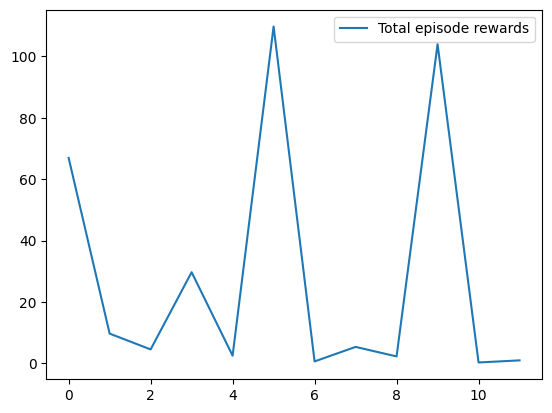

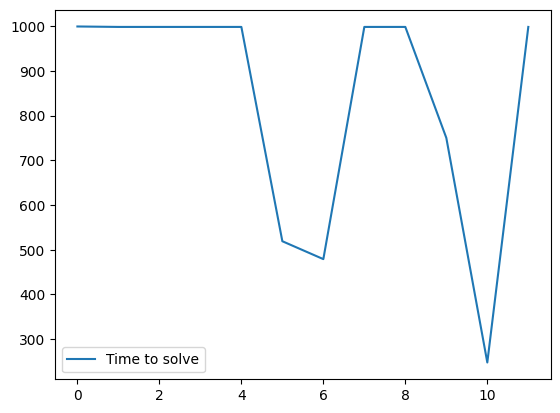

In [7]:
if __name__ == "__main__":
    main()

Here is some starter code for BonusGiver.

# Please answer the following questions

# #1 Basic Question

How many states are there? How many actions?


Infinite (continuous state space), infinite (continuous action space)

# #2 Finish BonusGiver, and implement it into your code from part 1.

Using bonuses, plot learning curves showing the following:

a) Sum of episode rewards vs time. That is, each data point on the y-axis is the sum of rewards for a given episode, and the x-axis is the total training steps.

b) 'Time to solve' vs time. The y-axis in this case is how long it takes the agent to reach the top of the cliff. When this happens, the agent receives a large reward and the episode terminates. Thus, this is the time it makes the agent to solve the environment on a per-episode basis.

c) Remake the plot from part a with no exploration bonuses. Is there a difference from your result in part a? Note in the case of implementing part a with no bonuses, you should instead use a reward of 0 if the environment is not solved. See below.

# #3 Does beta matter?

a) Try a few different values of beta. Does changing it improve performance? Use the 'time to solve' metric from 2.b

b) Finally, there are two common ways to return exploration bonuses based on state visitation. The first is: 1/N(s), one over the number of times the state is visited. The second is 1/(sqrt(N(s)), one over the square root of the state visitation count. Compare these using the 'sum of episodes rewards' metric from 2.a
